<a href="https://colab.research.google.com/github/Brian342/Real-Time-Smoke-Fire-Detection-YOLO11/blob/master/Fire_smoke_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 99.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [2]:
# import all the libraries
import ultralytics
from ultralytics import YOLO
from IPython.display import Image
from roboflow import Roboflow
# from google.colab import userdata
import os

ultralytics.checks()

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6633.0/8062.4 GB disk)


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=secret_value_0)
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
dataset1 = project.version(2).download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:02<00:00, 8145.98it/s] 


In [4]:
dataset1.location

'/kaggle/working/Fire-Smoke-Detection-Yolov11-2'

In [5]:
import yaml

file_path = f'{dataset1.location}/data.yaml'

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

data['train'] = os.path.join(dataset1.location, 'train', 'images')
data['val'] = os.path.join(dataset1.location, 'valid', 'images')
data['test'] = os.path.join(dataset1.location, 'test', 'images')

with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Path updated successfully")

Path updated successfully


In [6]:
# verification
from pprint import pprint
with open(file_path, 'r') as file:
    updated_data = yaml.safe_load(file)
    pprint(updated_data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images'}


In [7]:
# label cleaning
import os
from collections import defaultdict

def read_yolo_annotations_with_metadata(dataset_metadata):
    # Extract paths and class names
    train_path = dataset_metadata['train'].replace('images', 'labels')
    val_path = dataset_metadata['val'].replace('images', 'labels')
    test_path = dataset_metadata['test'].replace('images', 'labels')
    class_names = dataset_metadata['names']

    # Storage variables
    split_stats = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }

    def process_labels(label_dir, split_name):
        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)

            # Read annotations
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            # Find present classes
            present_classes = set()
            for line in lines:
                class_id = int(line.strip().split()[0])
                present_classes.add(class_id)

            # Update counts
            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1

    # Process all datasets
    process_labels(train_path, 'train')
    process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return {
        'class_stats': split_stats,
        'class_names': class_names
    }

# Updated for Kaggle environment
dataset_metadata = {
    'names': ['Fire', 'Smoke'],
    'nc': 2,
    # dataset1 is the variable from your Roboflow download cell
    'test': os.path.join(dataset1.location, 'test', 'images'),
    'train': os.path.join(dataset1.location, 'train', 'images'),
    'val': os.path.join(dataset1.location, 'valid', 'images')
}

# Run the cleaning/stats function again
results = read_yolo_annotations_with_metadata(dataset_metadata)

# Print the report
print("Paths corrected! Distribution Report:\n")
for split in ['train', 'val', 'test']:
    stats = results['class_stats'][split]
    total = sum(stats.values())
    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only: {stats['fire_only']} ({stats['fire_only']/total:.1%})")
    print(f"- Smoke only: {stats['smoke_only']} ({stats['smoke_only']/total:.1%})")
    print(f"- Both present: {stats['both']} ({stats['both']/total:.1%})")
    print(f"- Background (neither): {stats['background']} ({stats['background']/total:.1%})")
    print()

Paths corrected! Distribution Report:

TRAIN SET (9156 images)
- Fire only: 5963 (65.1%)
- Smoke only: 1674 (18.3%)
- Both present: 1515 (16.5%)
- Background (neither): 4 (0.0%)

VAL SET (872 images)
- Fire only: 598 (68.6%)
- Smoke only: 127 (14.6%)
- Both present: 147 (16.9%)
- Background (neither): 0 (0.0%)

TEST SET (435 images)
- Fire only: 274 (63.0%)
- Smoke only: 79 (18.2%)
- Both present: 82 (18.9%)
- Background (neither): 0 (0.0%)



In [8]:
# custom dataset
!yolo task=detect mode=train \
data={dataset1.location}/data.yaml \
model=yolo11s.pt \
epochs=300 \
imgsz=640 \
batch=16 \
patience=50 \
optimizer='AdamW' \
cls=2.0 \
box=7.5 \
close_mosaic=20 \
project=fire_detection \
name=smoke_model_v2_small

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=2.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Fire-Smoke-Detection-Yolov11-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=smoke_model_v2_small, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, pati

In [9]:
import shutil
import os
from IPython.display import FileLink

# 1. Create a ZIP file of your entire training folder
# This includes weights, charts, and confusion matrices
shutil.make_archive('fire_smoke_results', 'zip', '/kaggle/working/fire_detection/smoke_model')

# 2. Generate a download link
FileLink(r'fire_smoke_results.zip')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/fire_detection/smoke_model'

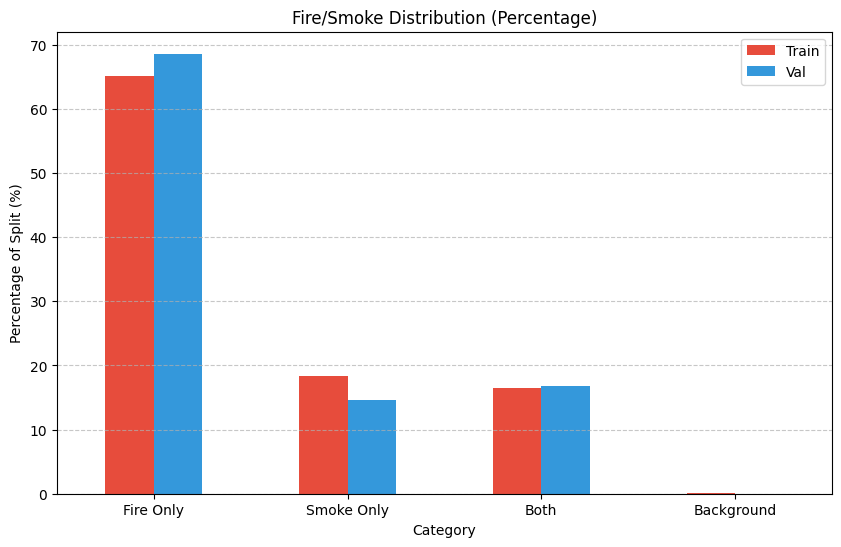

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your results
data = {
    'Category': ['Fire Only', 'Smoke Only', 'Both', 'Background'],
    'Train': [5963, 1674, 1515, 4],
    'Val': [598, 127, 147, 0]
}

df = pd.DataFrame(data).set_index('Category')
# Normalize to percentages
df_percent = df.div(df.sum(axis=0), axis=1) * 100

df_percent.plot(kind='bar', figsize=(10, 6), color=['#e74c3c', '#3498db'])
plt.title('Fire/Smoke Distribution (Percentage)')
plt.ylabel('Percentage of Split (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1]:
import os
from IPython.display import Image, display

# Path to your specific training run
results_dir = '/kaggle/working/fire_detection/smoke_model'

# Find the labels file
labels_path = os.path.join(results_dir, 'labels.jpg')

if os.path.exists(labels_path):
    display(Image(filename=labels_path, width=600))
else:
    print(f"❌ File not found at {labels_path}")
    print("Checking what files DO exist in that folder:")
    if os.path.exists(results_dir):
        print(os.listdir(results_dir))
    else:
        print(f"The folder {results_dir} hasn't been created yet. Did the training start successfully?")

❌ File not found at /kaggle/working/fire_detection/smoke_model/labels.jpg
Checking what files DO exist in that folder:
The folder /kaggle/working/fire_detection/smoke_model hasn't been created yet. Did the training start successfully?


In [ ]:
# Examine Training Results
Image("/kaggle/working/Fire-Smoke-Detection-Yolov11-2/runs/detect/train/confusion_matrix.png", width=600)


In [ ]:
Image("/kaggle/working/runs/detect/train/labels.jpg", width=600)

In [ ]:
Image("/kaggle/working/runs/detect/train/results.png", width=600)

In [ ]:
Image("/kaggle/working/runs/detect/train/train_batch0.jpg", width=600)

In [ ]:
Image("/kaggle/working/runs/detect/train/val_batch0_pred.jpg", width=600)

In [ ]:
Image("/kaggle/working/runs/detect/train/val_batch1_pred.jpg", width=600)

In [ ]:
!yolo task=detect mode=train \
data={dataset.location}/data.yaml \
model=yolo11n.pt \
epochs=250 \
imgsz=640 \
batch=32 \
patience=20 \
project=fire_detection \
name=smoke_model

!yolo task=detect mode=val model="/kaggle/working/runs/detect/train/weights/best.pt" data={dataset.location}/data.yaml